Mercari Interactive EDA + Topic Modeling

https://www.kaggle.com/thykhuely/mercari-interactive-eda-topic-modelling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
dtype = {'train_id':'int32','name':'object','item_condition_id':'int8','category_name':'object','brand_name':'object',
         'price':'float32','shipping':'int8','item_description':'object'}
train = pd.read_csv('/home/kyohei/.kaggle/competitions/mercari-price-suggestion-challenge/train.tsv',sep='\t',dtype=dtype)
test = pd.read_csv('/home/kyohei/.kaggle/competitions/mercari-price-suggestion-challenge/test.tsv',sep='\t',dtype=dtype)

In [3]:
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


In [4]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
#分布は0付近に偏るため、ログプロットする。
train.price.describe()

count    1.482535e+06
mean     2.673939e+01
std      3.852536e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

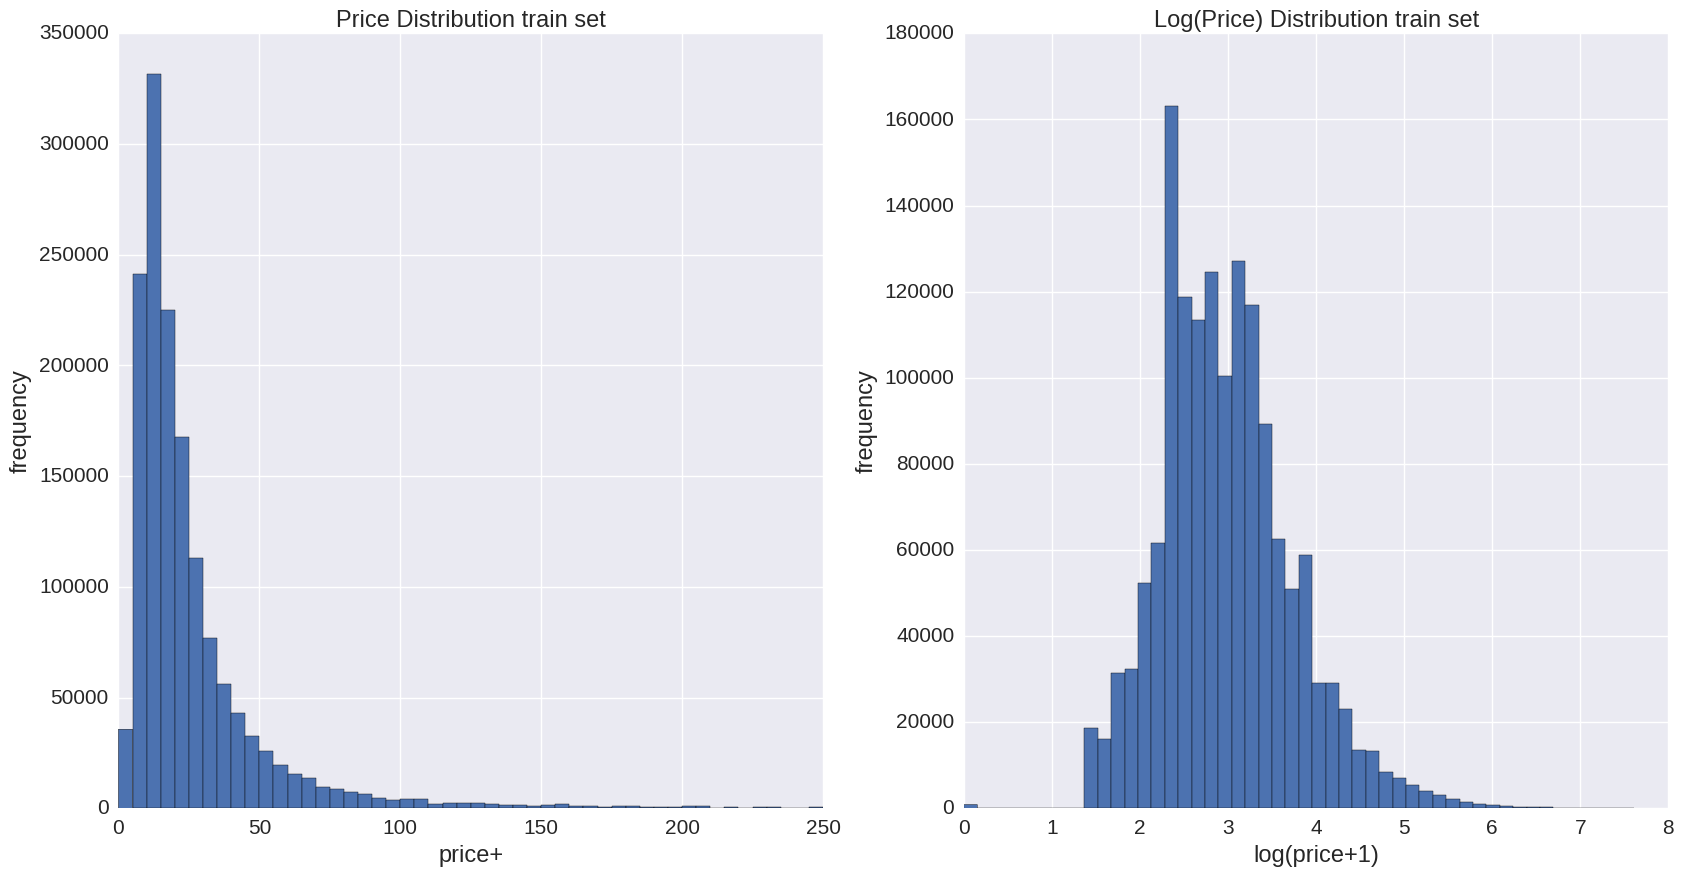

In [6]:
fig,axes = plt.subplots(1,2,figsize=(20,10))
train.price.plot(kind='hist',bins=50,edgecolor='black',range=[0,250],ax=axes[0])
axes[0].set_xlabel('price+',fontsize=17)
axes[0].set_ylabel('frequency',fontsize=17)
axes[0].tick_params(labelsize=15)
axes[0].set_title('Price Distribution train set',fontsize=17)

np.log(train.price+1).plot(kind='hist',bins=50,edgecolor='black',ax=axes[1])
axes[1].set_xlabel('log(price+1)',fontsize=17)
axes[1].set_ylabel('frequency',fontsize=17)
axes[1].tick_params(labelsize=15)
axes[1].set_title('Log(Price) Distribution train set',fontsize=17)
plt.show()

In [7]:
train.shipping.value_counts() / len(train)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

In [8]:
prc_shipByseller = train.loc[train.shipping==1,'price']
prc_shipByBuyer = train.loc[train.shipping==0,'price']

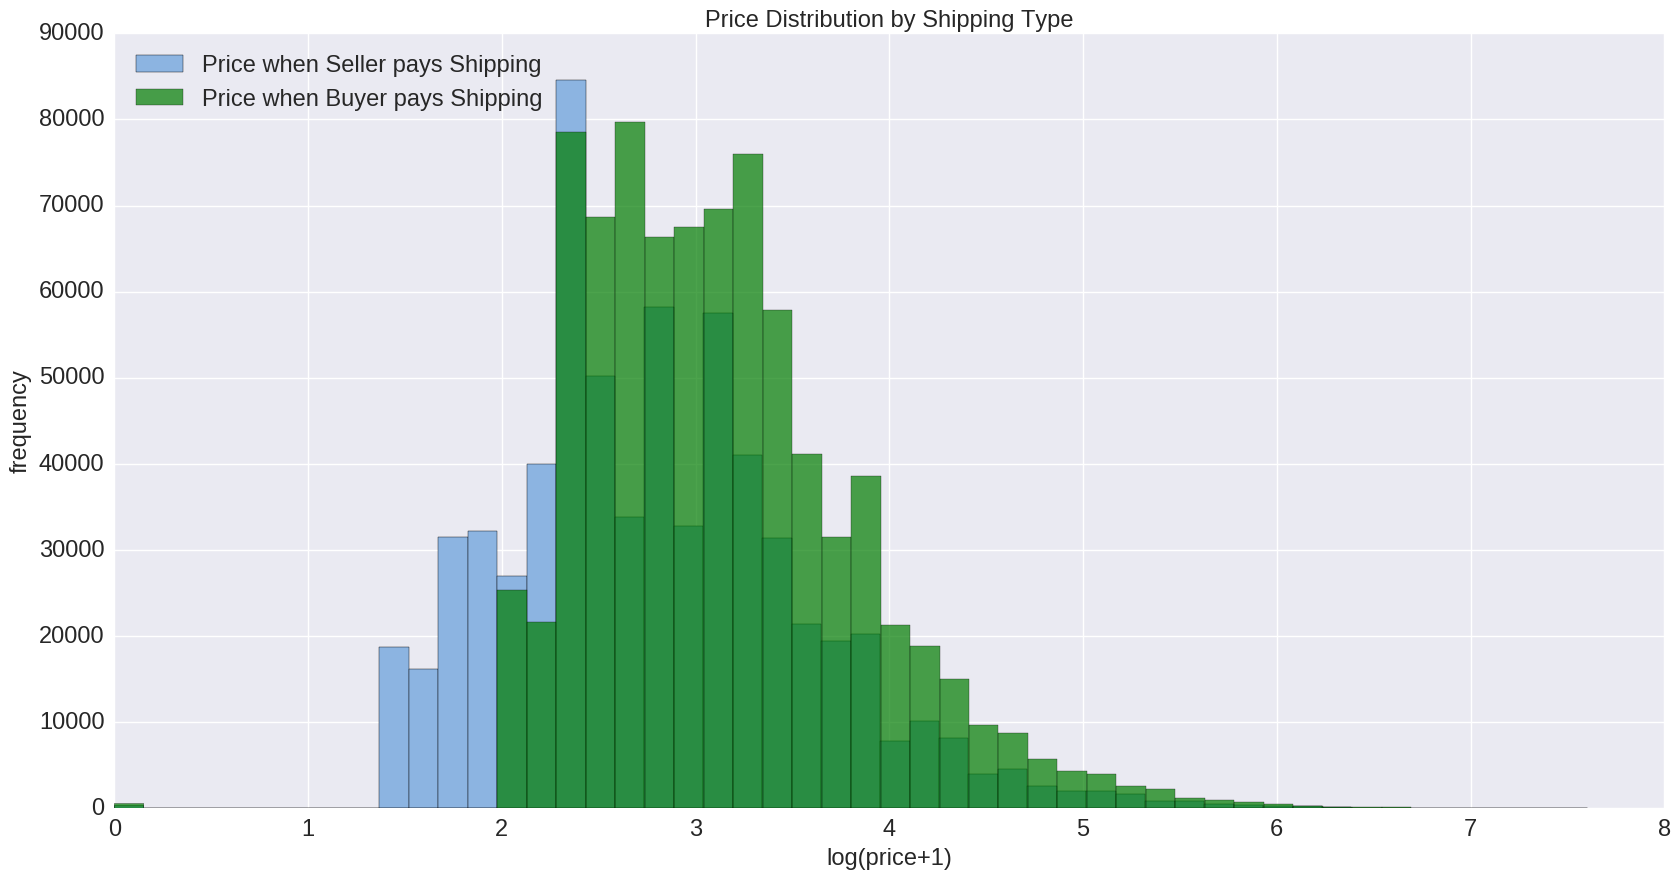

In [9]:
fig ,ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(prc_shipByseller+1),color='#8CB4E1',alpha=1.0,bins=50,
        label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer+1),color='#007D00',alpha=0.7,bins=50,
        label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison',ylabel='% of Dataset in Bin')
plt.xlabel('log(price+1)',fontsize=17)
plt.ylabel('frequency',fontsize=17)
plt.title('Price Distribution by Shipping Type',fontsize=17)
plt.tick_params(labelsize=17)
plt.legend(loc='upper left',fontsize=17)
plt.show()

In [10]:
print("There are {0} unique values in the category columns".format(train.category_name.nunique()))

There are 1287 unique values in the category columns


In [11]:
#Top 5
train.category_name.value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [12]:
#missing categories
print('There are {0} items that do not have a label'.format(train.category_name.isnull().sum()))

There are 6327 items that do not have a label


In [13]:
#category_nameそ分割する
def split_cat(text):
    try: return text.split('/')
    except: return('No label','No label', 'No label')

In [14]:
#*は行列の変換。
train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [20]:
#repeat the same step for the test set
test['general_cat'], test['subcat_1'], test['subcat_2'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))

In [21]:
print('There are {0} unique first sub-categories'.format(train.subcat_1.nunique()))

There are 114 unique first sub-categories


In [22]:
print('There are {0} unique second sub-categories'.format(train.subcat_2.nunique()))

There are 871 unique second sub-categories


In [23]:
x = train.general_cat.value_counts().index.values.astype('str')
y = train.general_cat.value_counts().values
pct = [('{:.2f}'.format(v*100))+'%' for v in (y/float(len(train)))]

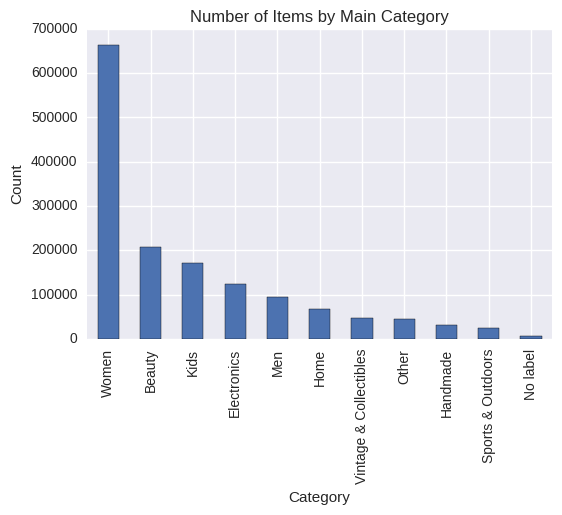

In [24]:
train.general_cat.value_counts().plot(kind='bar')
plt.title('Number of Items by Main Category')
plt.ylabel('Count')
plt.xlabel('Category',)

In [25]:
data_box = pd.concat([np.log(train.price),train.general_cat],axis=1)

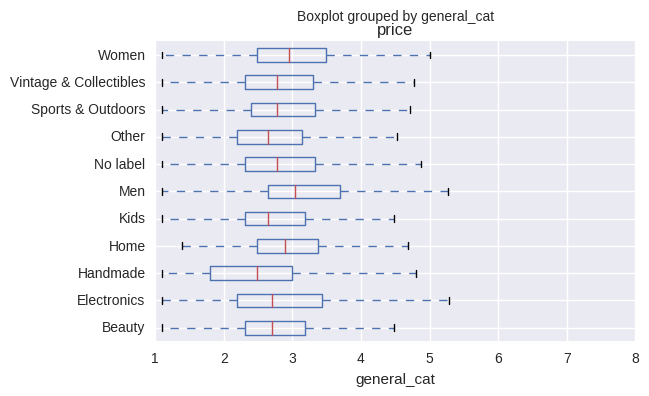

In [26]:
data_box.boxplot(column='price',by='general_cat',vert=False)

In [27]:
import re
import string
from sklearn.feature_extraction import stop_words

#記述に中に含まれる文字数をカウントする。ただし、ストップワードや数字は含まない。
def wordCount(text):
    try:        
        text = text.lower()
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        #regexに含まれる文字がtextにあった場合" "に変換する。
        txt = regex.sub(' ',text)
        #stopwordsに含まれず、かつ、3文字以上の場合
        words = [w for w in txt.split(' ') \
                if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except:
        return 0

stringには、文字列に関係した変数や関数が含まれている。主に、
- 特定のグループの文字列をまとめた変数
- 文字列をフォーマットする関数
の2つが入っている。

https://www.lifewithpython.com/2013/04/string.html

In [28]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
#re moduleで使えるようにエスケープする。
re.escape(string.punctuation)

'\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^\\_\\`\\{\\|\\}\\~'

In [35]:
train['desc_len'] = train['item_description'].apply(lambda x:wordCount(x))

In [36]:
test['desc_len'] = test['item_description'].apply(lambda x:wordCount(x))

In [37]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,1
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,14
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,8
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,14
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3


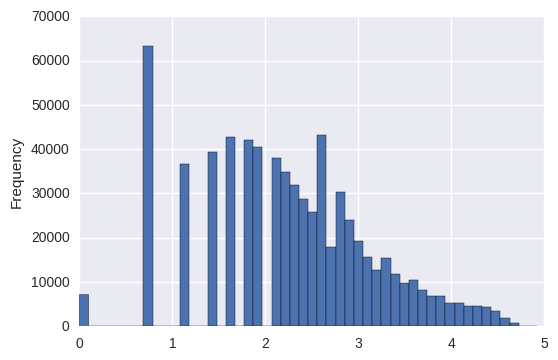

In [38]:
#文字数の分布
np.log(test.desc_len+1).plot(kind='hist',bins=50)

In [39]:
#文字数と価格の関係
df = train.groupby('desc_len')['price'].mean().reset_index()

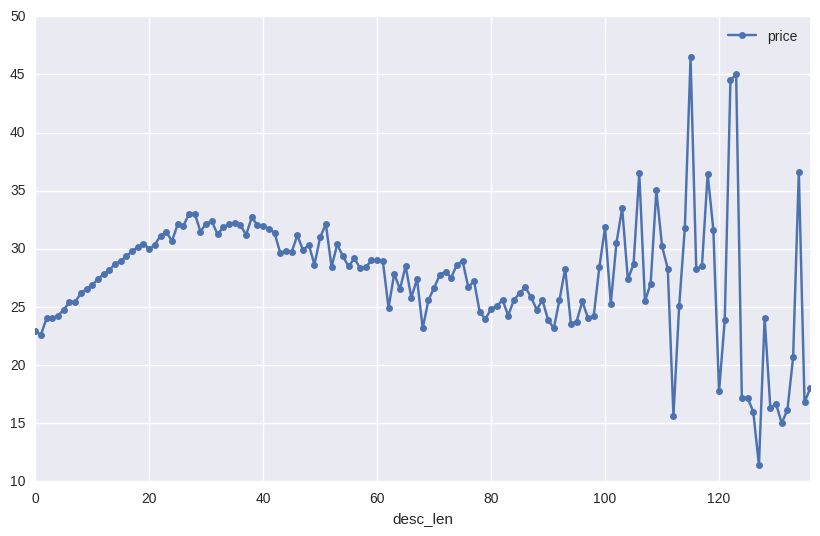

In [40]:
df.plot(kind='line',x='desc_len',y='price',figsize=(10,6),linestyle='-',marker='o',markersize=5)

In [42]:
#descriptionが欠損値の数
train.item_description.isnull().sum()

4

In [43]:
train = train[pd.notnull(train.item_description)]

In [44]:
import nltk
from nltk.corpus import stopwords

In [74]:
from nltk.tokenize import sent_tokenize, word_tokenize
stop = set(stopwords.words('english'))
def tokenize(text):
    
    try:
        regex = re.compile('[' +re.escape(string.punctuation)+'0-9\\r\\t\\n]')
        text = regex.sub(' ',text) #remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        #stopwordsに含まれないものだけ抽出
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
    
    except TypeError as e: print(test,e)

In [ ]:
#apply the tokenizer into the item description column
train['tokens'] = train.item_description.map(tokenize)
test['tokens'] = test.item_description.map(tokenize)

In [ ]:
for decription, tokens in zip(train.item_description.head(),
                              train.tokens.head()):
    print('description:',description)
    print('tokens:',tokens)
    print()